In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties


file_vwnd = './dataset/V-WIND.nc'
file_uwnd = './dataset/U-WIND.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)

vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']


cor_num = pd.read_excel(io = r'./dataset/SI0719.xlsx')
coordinate = cor_num['SI'].tolist()

In [9]:
# 先经过这一步计算, 
# 就是用[(u的200level减去850level)的平方+(v的200level减去850level)的平方]再根号
# vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
# vlevel_200 = vwnd[:1,9:10].data[0][:,:][0]

# ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]
# ulevel_200 = uwnd[:1,9:10].data[0][:,:][0]
def diff_square(a, b):
    # 求两相同大小的矩阵个元素之间的平方和
    vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
    _square = np.zeros(vlevel_850.shape, dtype=float, order='C')
    for i in range(len(a)):
        for j in range(len(a[0])):
            tmp = (a[i][j] - b[i][j])**2
            _square[i][j] = tmp
    return _square

def diff_sqrt(v_200, v_850, u_200, u_850):
    # 求矩阵每个元素的二次方根
    vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
    vlevel_sqrt = np.zeros(vlevel_850.shape, dtype=float, order='C') 
    vlevel_square = diff_square(v_200, v_850)
    ulevel_square = diff_square(u_200, u_850)

    for i in range(len(vlevel_square)):
        for j in range(len(vlevel_square[i])):
            tmp = vlevel_square[i][j] + ulevel_square[i][j]
            vlevel_sqrt[i][j] = sqrt(tmp)
    return vlevel_sqrt

def num_month_12toNext4(a):
    num_months = (a - 1948) * 12
    start = num_months+11
    end = start + 5
    return start, end

# 循环时间
def sum_year(start, end, vwnd, uwnd):
    '''
    计算平均值
    '''
    sum_months = np.zeros(vwnd[:1,0:1].data[0][:,:].shape, dtype=float, order='C')
    for i in range(start, end): 
        tmp_vlevel_850 = vwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_vlevel_200 = vwnd[i:i+1,9:10].data[0][:,:][0]
        tmp_ulevel_850 = uwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_ulevel_200 = uwnd[i:i+1,9:10].data[0][:,:][0]

        tmp_vwp = diff_sqrt(tmp_vlevel_200, tmp_vlevel_850, tmp_ulevel_200, tmp_ulevel_850)

        sum_months += tmp_vwp
#     diff_mean = sum_m
    return sum_months

def vws(startYear, endYear, vwnd, uwnd):
    num_year = endYear-startYear
    vorticity_mean = np.zeros((num_year,73,144), dtype=float, order='C')
    for year in range(startYear, endYear):
        start, end = num_month_12toNext4(year)
        vort_tmp = sum_year(start, end, vwnd, uwnd)
#         print(vort_tmp)
        index = year - startYear
#         print(index)
        vorticity_mean[index:index+1,:,:] = vort_tmp
    return vorticity_mean





In [41]:
vws_1980to2004 = vws(1979, 2004, vwnd, uwnd).transpose(1,2,0)
vws_2005to2023 = vws(2004, 2023, vwnd, uwnd).transpose(1,2,0)

In [35]:
def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((73,144), dtype=float, order='C')
    p_value = np.zeros((73,144), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 25:
                y = coordinate[:25]
            elif len(x) == 19:
                y = coordinate[25:]
            else:
                break
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value


In [43]:
# 计算相关性系数
pearson_matrix_1980to2004, p_value_1980to2004 = PearsonMatrix(vws_1980to2004)
pearson_matrix_2005to2023, p_value_2005to2023 = PearsonMatrix(vws_2005to2023)



In [44]:
# 求相关行系数的最大值和最小值
print(pearson_matrix_1980to2004.max(), pearson_matrix_1980to2004.min())
print(pearson_matrix_2005to2023.max(), pearson_matrix_2005to2023.min())

0.7036984633389061 -0.7424123612396721
0.5822362340618537 -0.6762430296027258


In [45]:
print(p_value_1980to2004.max(), p_value_1980to2004.min())
print(p_value_2005to2023.max(), p_value_2005to2023.min())

0.9997826936065278 2.1447060525600485e-05
0.9999868733986867 0.0014786769906852658


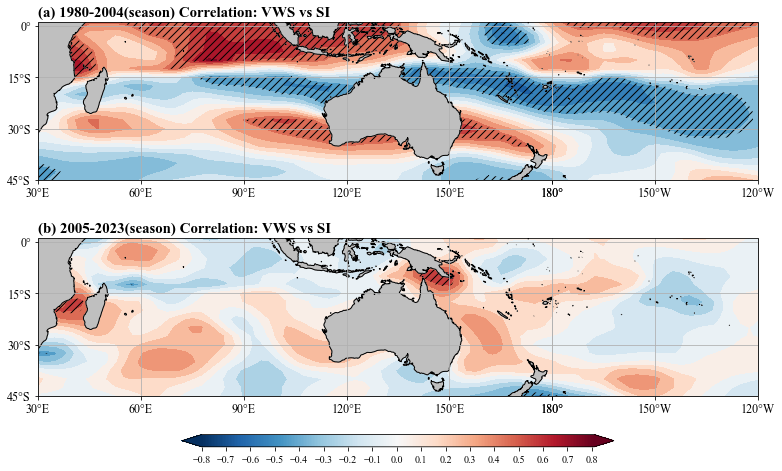

In [56]:
plt.rc('font',family='Times New Roman') 
# 纬度转换成太平洋为中心，增加360度一度
lon = np.append(vlon[:].data, [360.0])
# lon = vlon[:].data
# 取经度数据
lat = vlat[18:55].data

MIN = -0.8
MAX = 0.8

# new_diff = pearson_matrix
diff_2d = pearson_matrix_1980to2004[18:55,:]
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff_1988to1997=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff_1988to1997.append(tmp.tolist())
new_diff_1988to1997 = np.array(new_diff_1988to1997)

fig = plt.figure(figsize=(10,10))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (30, 180.1, -45, 1)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0.4, 1, 1], projection = proj)

fig_ax1.contourf(vlon[:].data, lat, p_value_1980to2004[18:55,:],
                [np.nanmin(p_value_1980to2004[18:55,:]), 0.05, np.nanmax(p_value_1980to2004[18:55,:])],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

xticks_list = np.hstack((np.arange(30,180.1,30) , np.arange(-180,-90.1,30)))
fig_ax1.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1980-2004(season) Correlation: VWS vs SI',fontweight='bold',
                  loc='left',fontsize =15)

cont_ax1 = fig_ax1.contourf(lon, lat, new_diff_1988to1997, 
                 levels=np.arange(-0.81,0.81,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

# ======================= 图2 =============================
diff_3d = pearson_matrix_2005to2023[18:55,:]
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff_1998to2021=[]
for i in range(diff_3d.shape[0]):
    tmp = np.append(diff_3d[i], diff_3d[i][0])
    new_diff_1998to2021.append(tmp.tolist())
new_diff_1998to2021 = np.array(new_diff_1998to2021)

fig_ax2 = fig.add_axes([0, 0.1, 1, 1], projection = proj)

fig_ax2.contourf(vlon[:].data, lat, p_value_2005to2023[18:55,:],
                [np.nanmin(p_value_2005to2023[18:55,:]), 0.05, np.nanmax(p_value_2005to2023[18:55,:])],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax2.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 2005-2023(season) Correlation: VWS vs SI',fontweight='bold',
                  loc='left',fontsize =15)

cont_ax1 = fig_ax2.contourf(lon, lat, new_diff_1998to2021, 
                 levels=np.arange(-0.81,0.81,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

position = fig.add_axes([0.2, 0.42, 0.6, 0.017]) # 最下面位置

norm = colors.Normalize(vmin=-0.8, vmax=0.81)    #确定colormap的最大最小值

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 cax = position,
                 orientation='horizontal',
                 ticks=np.arange(-0.80,0.81,0.1).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.012) 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
# fc1.set_label(label="[m/s]", fontdict=font) #设置colorbar的标签字体及其大小

plt.savefig("vws_corl_12toNext4.png",dpi=300,bbox_inches='tight')
plt.show()